In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('.')) 
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import polars as pl 
import pandas as pd 
import numpy as np

import sys
import os

import mlflow

from modelo_propension.config import DATA_DIR
from modelo_propension.modeling.optuna_hyperparameters import optimize_xgboost, optimize_random_forest, optimize_catboost
from modelo_propension.funciones_apoyo import  missing_values_table, create_and_analyze_summary

from feature_engine.transformation import LogTransformer
import time
from sklearn import base, pipeline, preprocessing
from feature_engine import encoding, imputation, creation, selection, discretisation, outliers

from modelo_propension.VennABERS import ScoresToMultiProbs

2024-07-26 17:25:32.118 | INFO     | modelo_propension.config:<module>:11 - PROJ_ROOT path is: C:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG
c:\Users\DF357JZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
module_path = os.path.abspath(os.path.join('.')) + 'modelo_propension\modelling'
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('..')) + 'modelo_propension\modelling'
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
#df1["CIUDAD_DEPARTAMENTO_1"]=df1.groupby(["CIUDAD","DEPARTAMENTO"])["AA_VLR_ING_BRU_MES"].transform('mean')
#df1["EDUCATIVO_CIUDAD_1"]=df1.groupby(["NIVEL_EDUCATIVO","CIUDAD"])["AA_VLR_ING_BRU_MES"].transform('mean')
#df1["EDUCATIVO_CIUDAD_2"]=df1.groupby(["NIVEL_EDUCATIVO","CIUDAD"])["SALDO_TOTAL"].transform('mean')
#df1["CIUDAD_DEPARTAMENTO_2"]=df1.groupby(["CIUDAD","DEPARTAMENTO"])["SALDO_TOTAL"].transform('mean')

In [4]:
df = pl.scan_parquet(str(DATA_DIR) + "\interim\df_camp_fs.parquet").lazy()

In [33]:
df.group_by('FECHA_BASE').agg(pl.len(),pl.col('RESULTADO').sum().alias('TP'),pl.col('RESULTADO').mean()).sort('FECHA_BASE').collect().to_pandas()

,FECHA_BASE,len,TP,RESULTADO
0,202306,239737,19272,0.080388
1,202307,45038,386,0.008571
2,202308,6460,529,0.081889
3,202309,290567,13662,0.047018
4,202310,10142,66,0.006508
5,202311,25227,468,0.018552
6,202312,398345,12449,0.031252
7,202401,104935,1661,0.015829
8,202402,232751,1604,0.006891
9,202403,481883,6956,0.014435


## DIVIDIR DATASET

In [5]:
train = df.filter(pl.col('FECHA_BASE').is_between(202306,202402)).clone()
test = df.filter(pl.col('FECHA_BASE')==202403).clone()
validation = df.filter(pl.col('FECHA_BASE')==202404).clone()

In [7]:
X_train_raw = train.drop('RESULTADO').collect()
y_train = train.select('RESULTADO').collect().to_pandas()

X_test_raw = test.drop('RESULTADO').collect()
y_test = test.select('RESULTADO').collect().to_pandas()

X_validation_raw = validation.drop('RESULTADO').collect()
y_validation = validation.select('RESULTADO').collect().to_pandas()

## CREAR PIPELINE

In [8]:
missing_values_table(df.collect())

Your selected dataframe has 124 columns.
There are 2 columns that have missing values.


(shape: (2, 3)
 ┌──────────────────┬──────────────┬────────────┐
 │ columnas         ┆ num_missings ┆ % missings │
 │ ---              ┆ ---          ┆ ---        │
 │ str              ┆ i64          ┆ f64        │
 ╞══════════════════╪══════════════╪════════════╡
 │ EDAD             ┆ 43436        ┆ 2.226039   │
 │ ANTIGUEDAD_MESES ┆ 43436        ┆ 2.226039   │
 └──────────────────┴──────────────┴────────────┘,
 ['EDAD', 'ANTIGUEDAD_MESES'])

In [9]:
def preprocess_X(train: pl.DataFrame):

    preprocessed_train = train.clone()

    preprocessed_train = (
        preprocessed_train
        .with_columns(pl.when(pl.col('DISPONIBLE_CTA')<0).then(pl.lit(0)).otherwise(pl.col('DISPONIBLE_CTA')).alias('DISPONIBLE_CTA'))
        .with_columns(pl.when(pl.col('SALDO_CUENTA')<0).then(pl.lit(0)).otherwise(pl.col('SALDO_CUENTA')).alias('SALDO_CUENTA'))
        .with_columns(pl.when(pl.col('AA_VLR_ING_BRU_MES')<0).then(pl.lit(0)).otherwise(pl.col('AA_VLR_ING_BRU_MES')).alias('AA_VLR_ING_BRU_MES'))
    
    .drop(['FECHA_BASE','DEFINIT'])
    )

    return preprocessed_train.to_pandas()

In [10]:
class TweakDataTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, ycol=None):
        self.ycol = ycol
    
    def transform(self, X):
        return preprocess_X(X)
    
    def fit(self, X, y=None):
        return self

data_pipeline = pipeline.Pipeline([
    ("tweak", TweakDataTransformer()),
    #("missing flag", imputation.AddMissingIndicator(variables=['reemplazar'])),
    #("missing", imputation.CategoricalImputer()), # fill_value = Missing
    #("decisionTreeEncoder", decision_tree_encoder),
    ("outliers", outliers.Winsorizer(
        capping_method='quantiles',
        tail='right',
        fold=0.05,
        variables=['AA_VLR_ING_BRU_MES','AA_VLR_PASIVOS','SALDO_PASIVOS']
    )),
    ("missing numeric", imputation.MeanMedianImputer(variables=['EDAD', 'ANTIGUEDAD_MESES'])),
    ("rare", encoding.RareLabelEncoder(n_categories=10)),
    ("ohe", encoding.OneHotEncoder(drop_last=True)),
    #("math1", creation.RelativeFeatures(variables=['resto de numericas'], reference=['aaaa_ing'], func=['div','mul','mod'], fill_value=0)), #! REEMPLAZAR
    ("corr", selection.DropCorrelatedFeatures(threshold=0.9)),
    ("constant", selection.DropConstantFeatures(tol=0.95)),
])

In [11]:
X_train_preprocessed = data_pipeline.fit_transform(X_train_raw, y_train)
X_test_preprocessed = data_pipeline.transform(X_test_raw)
X_validation_preprocessed = data_pipeline.transform(X_validation_raw)

c:\Users\DF357JZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable CANAL_VENTA is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\DF357JZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable MAR_STATUS is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\DF357JZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable NIVEL_EDUCATIVO is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\DF357JZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\feature_engine\encoding\r

## UNDERSAMPLING

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [13]:
## Oversample the minority class (positive class) by 4 times using SMOTE
#smote = SMOTE(sampling_strategy={1: y_train.value_counts()[1] * 2}, random_state=42)
#X_res, y_res = smote.fit_resample(X_train_preprocessed, y_train)
#
## Combine the oversampled data with the original data
#df_res = pd.concat([X_res, y_res], axis=1)

# Undersample the majority class (negative class) to match the increased positive class count
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_res, y_res = rus.fit_resample(X_train_preprocessed, y_train)

In [13]:
X_res = X_train_preprocessed.copy()
y_res = y_train.copy()

# OPTIMIZE HYPERPARAMETERS

In [15]:
rf_best_params = optimize_random_forest(X_res.reset_index(drop=True), y_res['RESULTADO'].values, n_trials=10, timeout=7200)

[I 2024-07-26 19:15:23,036] A new study created in memory with name: no-name-a79ad338-13ac-4c53-bdf7-9517aec9d578
[I 2024-07-26 19:26:29,397] Trial 0 finished with value: 0.7709609994896734 and parameters: {'n_estimators': 267, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7709609994896734.
[I 2024-07-26 19:31:21,113] Trial 1 finished with value: 0.7382137724538035 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 0 with value: 0.7709609994896734.
[I 2024-07-26 19:37:12,151] Trial 2 finished with value: 0.7276545118241877 and parameters: {'n_estimators': 190, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7709609994896734.


Best trial:
  Value: 0.7709609994896734
  Params:
    n_estimators: 267
    max_depth: 25
    min_samples_split: 12
    min_samples_leaf: 9
    max_features: sqrt


In [16]:
xgb_best_params = optimize_xgboost(X_res, y_res['RESULTADO'].values, n_trials=10, timeout=7200)

[I 2024-07-26 19:37:12,215] A new study created in memory with name: no-name-7d9aa859-b963-48eb-9d52-40d826517737
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
[I 2024-07-26 20:21:49,770] Trial 0 finished with value: 0.7533224931987145 and parameters: {'n_estimators': 855, 

Best trial:
  Value: 0.7533224931987145
  Params:
    n_estimators: 855
    max_depth: 8
    learning_rate: 0.007194186963154983
    subsample: 0.7294639129771547
    colsample_bytree: 0.5278723354153875
    min_child_weight: 28.11944480057683
    gamma: 0.004089602750666002
    reg_alpha: 3.936814234352606e-06
    reg_lambda: 1.0260127821111078e-06
    scale_pos_weight: 27


In [14]:
cb_best_params = optimize_catboost(X_res, y_res['RESULTADO'].values, n_trials=1, timeout=7200)

[I 2024-07-26 17:32:42,324] A new study created in memory with name: no-name-12051471-6294-4dc9-99ca-1ed5773d9de0
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:139: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


0:	learn: 0.6912706	total: 759ms	remaining: 1h 9m 52s
1:	learn: 0.6911632	total: 1.17s	remaining: 53m 57s
2:	learn: 0.6910816	total: 1.53s	remaining: 47m 5s
3:	learn: 0.6906762	total: 1.97s	remaining: 45m 16s
4:	learn: 0.6901739	total: 2.36s	remaining: 43m 30s
5:	learn: 0.6825221	total: 2.78s	remaining: 42m 34s
6:	learn: 0.6804423	total: 3.25s	remaining: 42m 43s
7:	learn: 0.6804423	total: 3.52s	remaining: 40m 30s
8:	learn: 0.6766396	total: 4.09s	remaining: 41m 50s
9:	learn: 0.6766392	total: 4.48s	remaining: 41m 13s
10:	learn: 0.6766387	total: 4.79s	remaining: 40m 4s
11:	learn: 0.6766383	total: 5.08s	remaining: 38m 55s
12:	learn: 0.6765885	total: 5.43s	remaining: 38m 22s
13:	learn: 0.6681234	total: 5.86s	remaining: 38m 27s
14:	learn: 0.6660574	total: 6.29s	remaining: 38m 31s
15:	learn: 0.6660566	total: 6.63s	remaining: 38m 2s
16:	learn: 0.6659658	total: 7.06s	remaining: 38m 6s
17:	learn: 0.6653465	total: 7.53s	remaining: 38m 23s
18:	learn: 0.6653458	total: 7.84s	remaining: 37m 54s
19:	l

[I 2024-07-26 19:15:21,718] Trial 0 finished with value: 0.7314508646672562 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.01661920974399769, 'depth': 5, 'l2_leaf_reg': 5.5, 'n_estimators': 5526, 'learning_rate': 0.0372294001777662, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9559708925903121}. Best is trial 0 with value: 0.7314508646672562.


Best trial:
  Value: 0.7314508646672562
  Params:
    objective: Logloss
    colsample_bylevel: 0.01661920974399769
    depth: 5
    l2_leaf_reg: 5.5
    n_estimators: 5526
    learning_rate: 0.0372294001777662
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.9559708925903121


## MODEL TRAINING

In [17]:
from xgboost import XGBClassifier
from sklearn import ensemble
import catboost as cb

import time

In [18]:
#For loop Modelo
estimators = []
RANDOM_STATE = 1901

for i in range(2):
    tmp_xgb = XGBClassifier(**xgb_best_params,n_jobs=-1,random_state=RANDOM_STATE+i)
    tmp_rf = ensemble.RandomForestClassifier(**rf_best_params,n_jobs=-1,random_state=RANDOM_STATE+i)
    #tmp_cat = cb.CatBoostClassifier(**cb_best_params,n_jobs=-1,random_state= RANDOM_STATE + i)
    estimators.append((f"xgb_{i}", tmp_xgb))
    estimators.append((f"rf_{i}", tmp_rf))
    #estimators.append((f"cat_{i}", tmp_cat))


#Voting
clf = ensemble.VotingClassifier(estimators= estimators, voting="soft")
clf.fit(X_res, pd.DataFrame(y_res, columns=['RESULTADO'])['RESULTADO'].values)

VotingClassifier(estimators=[('xgb_0',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5278723354153875,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.004089602750666002,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interact...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=28.11944480057683,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=855, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1902, ...)),
                             ('rf_1',
                              RandomForestClassifier(max_depth=25,
                                                     min_samples_leaf=9,
                                                     min_samples_split=12,
                                                     n_estimators=267,
                                                     n_jobs=-1,
                                                     random_state=1902))],
                 voting='soft')

In [47]:
from sklearn.inspection import permutation_importance

In [ ]:
from sklearn.inspection import permutation_importance

resultados_clf = permutation_importance(clf, X_test_preprocessed, y_test, scoring='recall_macro', random_state=1901)

# BORRAR

## RESULTADOS

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, log_loss, brier_score_loss, roc_auc_score, roc_curve, classification_report, make_scorer
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.calibration import calibration_curve

In [52]:
#Predicciones
y_pred = clf.predict(X_test_preprocessed)
#Métricas de evaluación
precision = precision_score(y_test.values, y_pred, average='micro')
recall = recall_score(y_test.values, y_pred, average='micro')
f1 = f1_score(y_test.values, y_pred, average='micro')
roc_auc = roc_auc_score(y_test.values,y_pred, average='micro')
cm = confusion_matrix(y_test.values, y_pred)

print(f'Precision (Micro): {precision}')
print(f'Recall (Micro): {recall}')
print(f'F1-Score (Micro): {f1}')
print(f'roc_auc (Micro): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

precision = precision_score(y_test.values, y_pred, average='macro')
recall_macro = recall_score(y_test.values, y_pred, average='macro')
f1 = f1_score(y_test.values, y_pred, average='macro')
roc_auc = roc_auc_score(y_test.values,y_pred, average='weighted')
cm = confusion_matrix(y_test.values, y_pred)

print(f'Precision (Macro): {precision}')
print(f'Recall (Macro): {recall_macro}')
print(f'F1-Score (Macro): {f1}')
print(f'roc_auc (Weighted): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

Precision (Micro): 0.9742634622927142
Recall (Micro): 0.9742634622927142
F1-Score (Micro): 0.9742634622927142
roc_auc (Micro): 0.6743102405037392
Confusion Matrix:
[[466939   7988]
 [  4414   2542]]
####################################################
Precision (Macro): 0.6160204883031866
Recall (Macro): 0.6743102405037392
F1-Score (Macro): 0.6388204129085671
roc_auc (Weighted): 0.6743102405037392
Confusion Matrix:
[[466939   7988]
 [  4414   2542]]
####################################################


In [53]:
#Predicciones
y_pred_validation = clf.predict(X_validation_preprocessed)
#Métricas de evaluación
precision = precision_score(y_validation.values, y_pred_validation, average='micro')
recall = recall_score(y_validation.values, y_pred_validation, average='micro')
f1 = f1_score(y_validation.values, y_pred_validation, average='micro')
roc_auc = roc_auc_score(y_validation.values,y_pred_validation, average='micro')
cm = confusion_matrix(y_validation.values, y_pred_validation)

print(f'Precision (Micro): {precision}')
print(f'Recall (Micro): {recall}')
print(f'F1-Score (Micro): {f1}')
print(f'roc_auc (Micro): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

precision = precision_score(y_validation.values, y_pred_validation, average='macro')
recall_macro = recall_score(y_validation.values, y_pred_validation, average='macro')
f1 = f1_score(y_validation.values, y_pred_validation, average='macro')
roc_auc = roc_auc_score(y_validation.values,y_pred_validation, average='weighted')
cm = confusion_matrix(y_validation.values, y_pred_validation)

print(f'Precision (Macro): {precision}')
print(f'Recall (Macro): {recall_macro}')
print(f'F1-Score (Macro): {f1}')
print(f'roc_auc (Weighted): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

Precision (Micro): 0.9851356469049094
Recall (Micro): 0.9851356469049094
F1-Score (Micro): 0.9851356469049094
roc_auc (Micro): 0.6635374790669338
Confusion Matrix:
[[114124   1070]
 [   657    333]]
####################################################
Precision (Macro): 0.6158122974935136
Recall (Macro): 0.6635374790669337
F1-Score (Macro): 0.6354011153395324
roc_auc (Weighted): 0.6635374790669338
Confusion Matrix:
[[114124   1070]
 [   657    333]]
####################################################


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

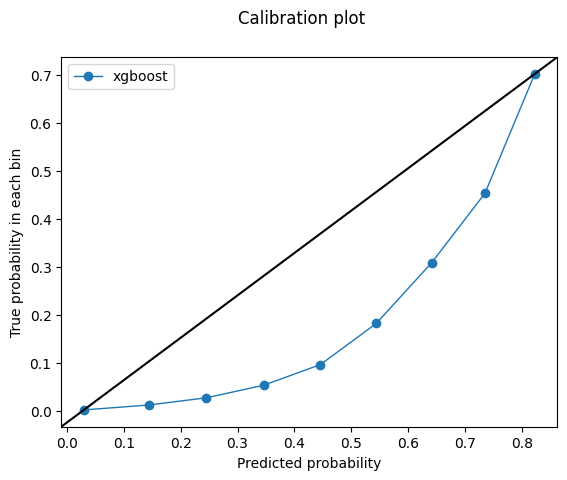

In [54]:
plt.style.use('default')

fig, ax = plt.subplots()

#Calibración del modelo 2 xgboost
prob_y_ensemble = clf.predict_proba(X_test_preprocessed)
ense_y, ense_x = calibration_curve(y_test.values, prob_y_ensemble[:,1], n_bins=10)

plt.plot(ense_x, ense_y, marker='o', linewidth=1, label='xgboost')

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [ ]:
def calibrate_probabilities(y_real, y_prediction, y_probs):
    
    return 

In [113]:
y_pred_validation = clf.predict_proba(X_validation_preprocessed)
testScores = y_pred_validation #prob_pos
y_pred
y_hat_cal_scores = clf.predict_proba(X_validation_preprocessed)[:,1]
calibrPts = zip(list(y_hat_cal_scores),list(y_validation['RESULTADO'].values))

In [125]:
y_pred_validation

array([[0.82034927, 0.17965073],
       [0.98667109, 0.01332892],
       [0.990126  , 0.009874  ],
       ...,
       [0.96255738, 0.03744261],
       [0.98067241, 0.01932759],
       [0.98067241, 0.01932759]])

In [114]:
p0,p1 = ScoresToMultiProbs(calibrPts,testScores)

In [115]:
prob_pos_calibrated = p1/(1-p0+p1)
calibrated_predictions = prob_pos_calibrated > 0.5

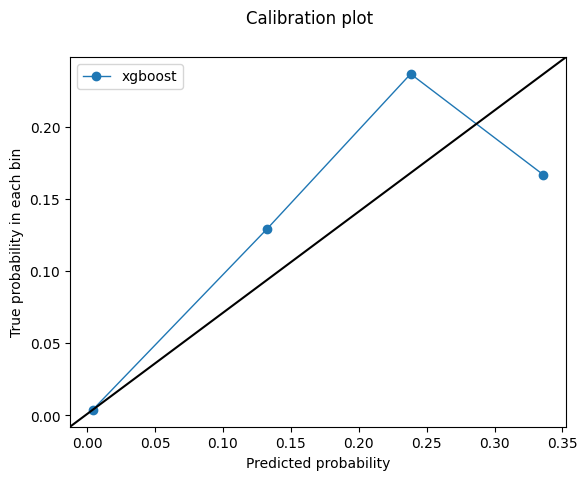

In [124]:
plt.style.use('default')

fig, ax = plt.subplots()

#Calibración del modelo 2 xgboost
#prob_y_ensemble = clf.predict_proba(X_test_preprocessed)
ense_y, ense_x = calibration_curve(y_validation['RESULTADO'].values, prob_pos_calibrated[:,1], n_bins=10)

plt.plot(ense_x, ense_y, marker='o', linewidth=1, label='xgboost')

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

###  MLFLOW

In [59]:
pd.DataFrame(confusion_matrix(y_test.values, y_pred)).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>0</th>\n      <th>1</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>466939</td>\n      <td>7988</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>4414</td>\n      <td>2542</td>\n    </tr>\n  </tbody>\n</table>'

In [73]:
mlflow.sklearn.autolog()
with mlflow.start_run():
    mlflow.sklearn.log_model(clf, "ensemble")
    mlflow.log_metric(
        "precission_macro_0_test",
        precision_score(y_test.values, y_pred, average='macro')
        )
    mlflow.log_metric(
        "recall_macro_0_test",
        recall_score(y_test.values, y_pred, average='macro')
        )
    mlflow.log_metric(
        "f1_macro_0_test",
        f1_score(y_test.values, y_pred, average='macro')
        )
    mlflow.log_metric(
        "roc_auc_macro_0_test",
        roc_auc_score(y_test.values,y_pred, average='weighted')
        )
    pd.DataFrame(confusion_matrix(y_test.values, y_pred)).to_html("cv_0_test.html")
    mlflow.log_artifact("cv_0_test.html", "cm_0_test")

    
    plt.style.use('default')

    fig, ax = plt.subplots()

    #Calibración del modelo 2 xgboost
    prob_y_ensemble = clf.predict_proba(X_test_preprocessed)
    ense_y, ense_x = calibration_curve(y_test.values, prob_y_ensemble[:,1], n_bins=10)

    plt.plot(ense_x, ense_y, marker='o', linewidth=1, label='xgboost')

    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle('Calibration plot')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.savefig("calibration_curve_0_test.png")
    
    mlflow.log_artifact("calibration_curve_0_test.png", "calibration_curve_0_test")

2024/07/28 01:21:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


MlflowException: Run '0' not found

In [71]:
mlflow.end_run()

# Second optimization

In [24]:
rf_best_params_2 = optimize_random_forest(X_res.reset_index(drop=True), y_res['RESULTADO'].values, n_trials=10, timeout=7200)

[I 2024-07-26 21:43:48,135] A new study created in memory with name: no-name-d33abf08-91c1-4d32-ac03-eaa516f42b9e
[I 2024-07-26 21:57:45,665] Trial 0 finished with value: 0.7721826885540811 and parameters: {'n_estimators': 311, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7721826885540811.
[I 2024-07-26 22:01:28,375] Trial 1 finished with value: 0.7271778203735192 and parameters: {'n_estimators': 110, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7721826885540811.
[I 2024-07-26 22:12:54,225] Trial 2 finished with value: 0.767966076048189 and parameters: {'n_estimators': 254, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7721826885540811.
[I 2024-07-26 22:19:11,843] Trial 3 finished with value: 0.7077613760532756 and parameters: {'n_estimators': 243, 'max_depth': 8,

Best trial:
  Value: 0.7721826885540811
  Params:
    n_estimators: 311
    max_depth: 27
    min_samples_split: 20
    min_samples_leaf: 14
    max_features: sqrt


In [25]:
xgb_best_params_2 = optimize_xgboost(X_res, y_res['RESULTADO'].values, n_trials=10, timeout=7200)

[I 2024-07-26 22:51:21,311] A new study created in memory with name: no-name-69a31961-f4a3-4f7f-83b7-3d2ad900177c
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
[I 2024-07-26 23:59:33,994] Trial 0 finished with value: 0.7563822667478147 and parameters: {'n_estimators': 665, 

Best trial:
  Value: 0.7563822667478147
  Params:
    n_estimators: 665
    max_depth: 15
    learning_rate: 0.001809707493175414
    subsample: 0.8618503658475458
    colsample_bytree: 0.3279364058014691
    min_child_weight: 2.286505244526506
    gamma: 0.3430632123183961
    reg_alpha: 0.011637133816510725
    reg_lambda: 1.676949973638218e-06
    scale_pos_weight: 14


In [26]:
cb_best_params_2 = optimize_catboost(X_res, y_res['RESULTADO'].values, n_trials=5, timeout=7200)

[I 2024-07-27 02:43:33,094] A new study created in memory with name: no-name-f90733df-b3b7-4149-93af-2324522bcca1
c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\modeling\optuna_hyperparameters.py:139: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),


0:	learn: 0.6931472	total: 385ms	remaining: 30m 51s
1:	learn: 0.6922869	total: 1.07s	remaining: 42m 48s
2:	learn: 0.6918113	total: 1.64s	remaining: 43m 48s
3:	learn: 0.6918113	total: 2.06s	remaining: 41m 14s
4:	learn: 0.6909290	total: 2.64s	remaining: 42m 19s
5:	learn: 0.6901380	total: 3.25s	remaining: 43m 18s
6:	learn: 0.6901380	total: 3.68s	remaining: 42m 1s
7:	learn: 0.6895108	total: 4.5s	remaining: 44m 58s
8:	learn: 0.6895108	total: 4.97s	remaining: 44m 11s
9:	learn: 0.6895108	total: 5.45s	remaining: 43m 35s
10:	learn: 0.6872943	total: 6.16s	remaining: 44m 46s
11:	learn: 0.6869478	total: 6.64s	remaining: 44m 16s
12:	learn: 0.6866162	total: 7.09s	remaining: 43m 35s
13:	learn: 0.6862549	total: 7.51s	remaining: 42m 53s
14:	learn: 0.6861457	total: 7.98s	remaining: 42m 31s
15:	learn: 0.6861457	total: 8.36s	remaining: 41m 45s
16:	learn: 0.6861457	total: 8.84s	remaining: 41m 32s
17:	learn: 0.6860717	total: 9.39s	remaining: 41m 40s
18:	learn: 0.6860717	total: 9.87s	remaining: 41m 27s
19:	l

[I 2024-07-27 05:07:32,785] Trial 0 finished with value: 0.7133491701149483 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02046310079149773, 'depth': 5, 'l2_leaf_reg': 4.0, 'n_estimators': 4809, 'learning_rate': 0.008009192260981695, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7133491701149483.


Best trial:
  Value: 0.7133491701149483
  Params:
    objective: Logloss
    colsample_bylevel: 0.02046310079149773
    depth: 5
    l2_leaf_reg: 4.0
    n_estimators: 4809
    learning_rate: 0.008009192260981695
    boosting_type: Ordered
    bootstrap_type: MVS


In [28]:
#For loop Modelo
estimators = []
RANDOM_STATE = 1901

for i in range(2):
    tmp_xgb = XGBClassifier(**xgb_best_params_2,n_jobs=-1,random_state=RANDOM_STATE+i)
    tmp_rf = ensemble.RandomForestClassifier(**rf_best_params_2,n_jobs=-1,random_state=RANDOM_STATE+i)
    tmp_cat = cb.CatBoostClassifier(**cb_best_params_2,random_state= RANDOM_STATE + i)
    estimators.append((f"xgb_{i}", tmp_xgb))
    estimators.append((f"rf_{i}", tmp_rf))
    estimators.append((f"cat_{i}", tmp_cat))


#Voting
clf_2 = ensemble.VotingClassifier(estimators= estimators, voting="soft")
clf_2.fit(X_res, pd.DataFrame(y_res, columns=['RESULTADO'])['RESULTADO'].values)

0:	learn: 0.6811494	total: 574ms	remaining: 46m
1:	learn: 0.6677245	total: 1.35s	remaining: 54m 2s
2:	learn: 0.6561857	total: 2s	remaining: 53m 32s
3:	learn: 0.6428775	total: 3s	remaining: 1h 10s
4:	learn: 0.6318998	total: 3.66s	remaining: 58m 34s
5:	learn: 0.6206411	total: 4.33s	remaining: 57m 42s
6:	learn: 0.6098983	total: 5.28s	remaining: 1h 24s
7:	learn: 0.5997352	total: 5.95s	remaining: 59m 27s
8:	learn: 0.5897666	total: 6.66s	remaining: 59m 13s
9:	learn: 0.5800469	total: 7.32s	remaining: 58m 31s
10:	learn: 0.5704820	total: 8.2s	remaining: 59m 35s
11:	learn: 0.5612136	total: 8.83s	remaining: 58m 49s
12:	learn: 0.5515455	total: 9.59s	remaining: 58m 59s
13:	learn: 0.5423930	total: 10.3s	remaining: 58m 36s
14:	learn: 0.5337408	total: 10.9s	remaining: 58m 11s
15:	learn: 0.5222753	total: 11.8s	remaining: 58m 52s
16:	learn: 0.5140949	total: 12.4s	remaining: 58m 11s
17:	learn: 0.5060684	total: 13s	remaining: 57m 43s
18:	learn: 0.4981966	total: 13.8s	remaining: 58m 7s
19:	learn: 0.4893380

VotingClassifier(estimators=[('xgb_0',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3279364058014691,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.3430632123183961,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interactio...
                                            min_child_weight=2.286505244526506,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=665, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1902, ...)),
                             ('rf_1',
                              RandomForestClassifier(max_depth=27,
                                                     min_samples_leaf=14,
                                                     min_samples_split=20,
                                                     n_estimators=311,
                                                     n_jobs=-1,
                                                     random_state=1902)),
                             ('cat_1',
                              <catboost.core.CatBoostClassifier object at 0x0000024F250ED650>)],
                 voting='soft')

In [128]:
#Predicciones
y_pred = clf_2.predict(X_test_preprocessed)
#Métricas de evaluación
precision = precision_score(y_test.values, y_pred, average='micro')
recall = recall_score(y_test.values, y_pred, average='micro')
f1 = f1_score(y_test.values, y_pred, average='micro')
roc_auc = roc_auc_score(y_test.values,y_pred, average='micro')
cm = confusion_matrix(y_test.values, y_pred)

print(f'Precision (Micro): {precision}')
print(f'Recall (Micro): {recall}')
print(f'F1-Score (Micro): {f1}')
print(f'roc_auc (Micro): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

precision = precision_score(y_test.values, y_pred, average='macro')
recall_macro = recall_score(y_test.values, y_pred, average='macro')
f1 = f1_score(y_test.values, y_pred, average='macro')
roc_auc = roc_auc_score(y_test.values,y_pred, average='weighted')
cm = confusion_matrix(y_test.values, y_pred)

print(f'Precision (Macro): {precision}')
print(f'Recall (Macro): {recall_macro}')
print(f'F1-Score (Macro): {f1}')
print(f'roc_auc (Weighted): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

Precision (Micro): 0.985591938292075
Recall (Micro): 0.985591938292075
F1-Score (Micro): 0.985591938292075
roc_auc (Micro): 0.5242367247111067
Confusion Matrix:
[[474598    329]
 [  6614    342]]
####################################################
Precision (Macro): 0.7479712861884149
Recall (Macro): 0.5242367247111067
F1-Score (Macro): 0.5412099492730144
roc_auc (Weighted): 0.5242367247111067
Confusion Matrix:
[[474598    329]
 [  6614    342]]
####################################################


In [129]:
#Predicciones
y_pred_validation = clf_2.predict(X_validation_preprocessed)
#Métricas de evaluación
precision = precision_score(y_validation.values, y_pred_validation, average='micro')
recall = recall_score(y_validation.values, y_pred_validation, average='micro')
f1 = f1_score(y_validation.values, y_pred_validation, average='micro')
roc_auc = roc_auc_score(y_validation.values,y_pred_validation, average='micro')
cm = confusion_matrix(y_validation.values, y_pred_validation)

print(f'Precision (Micro): {precision}')
print(f'Recall (Micro): {recall}')
print(f'F1-Score (Micro): {f1}')
print(f'roc_auc (Micro): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

precision = precision_score(y_validation.values, y_pred_validation, average='macro')
recall_macro = recall_score(y_validation.values, y_pred_validation, average='macro')
f1 = f1_score(y_validation.values, y_pred_validation, average='macro')
roc_auc = roc_auc_score(y_validation.values,y_pred_validation, average='weighted')
cm = confusion_matrix(y_validation.values, y_pred_validation)

print(f'Precision (Macro): {precision}')
print(f'Recall (Macro): {recall_macro}')
print(f'F1-Score (Macro): {f1}')
print(f'roc_auc (Weighted): {roc_auc}')
print('Confusion Matrix:')
print(cm)

print('####################################################')

Precision (Micro): 0.9911863939957309
Recall (Micro): 0.9911863939957309
F1-Score (Micro): 0.9911863939957309
roc_auc (Micro): 0.5028566828764757
Confusion Matrix:
[[115154     40]
 [   984      6]]
####################################################
Precision (Macro): 0.5609810517772336
Recall (Macro): 0.5028566828764756
F1-Score (Macro): 0.503578236550761
roc_auc (Weighted): 0.5028566828764757
Confusion Matrix:
[[115154     40]
 [   984      6]]
####################################################


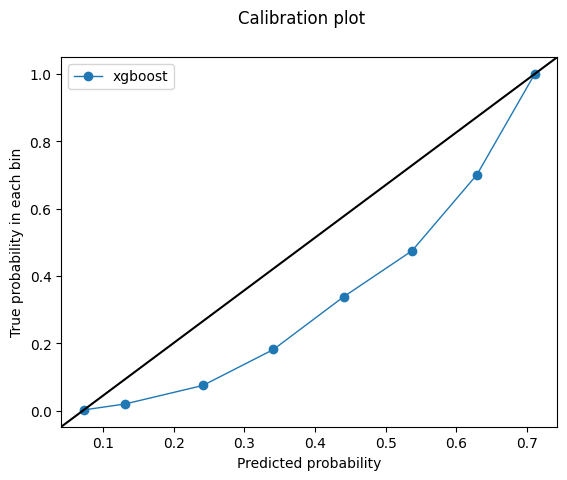

In [130]:
plt.style.use('default')

fig, ax = plt.subplots()

#Calibración del modelo 2 xgboost
prob_y_ensemble = clf_2.predict_proba(X_test_preprocessed)
ense_y, ense_x = calibration_curve(y_test.values, prob_y_ensemble[:,1], n_bins=10)

plt.plot(ense_x, ense_y, marker='o', linewidth=1, label='xgboost')

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [136]:
df_probar = pd.DataFrame()

df_probar['id'] = X_test_raw['DEFINIT']
df_probar['y_real'] = y_test.values
df_probar['y_prob'] = prob_y_ensemble[:,1]

In [140]:
from modelo_propension.funciones_apoyo import create_and_analyze_summary

ImportError: cannot import name 'create_and_analyze_summary' from 'modelo_propension.funciones_apoyo' (c:\Users\DF357JZ\OneDrive - EY\Banco Bogota\modelo-propension-camp-as-BGG\modelo_propension\funciones_apoyo.py)

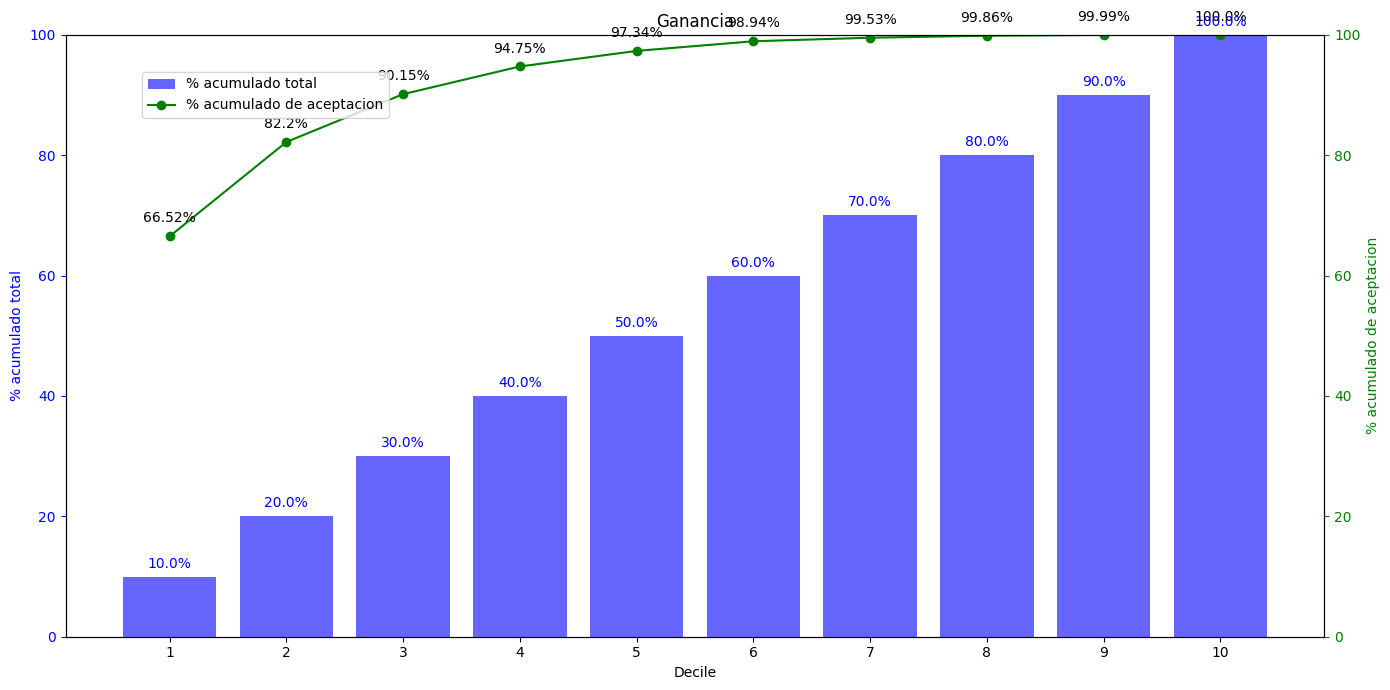

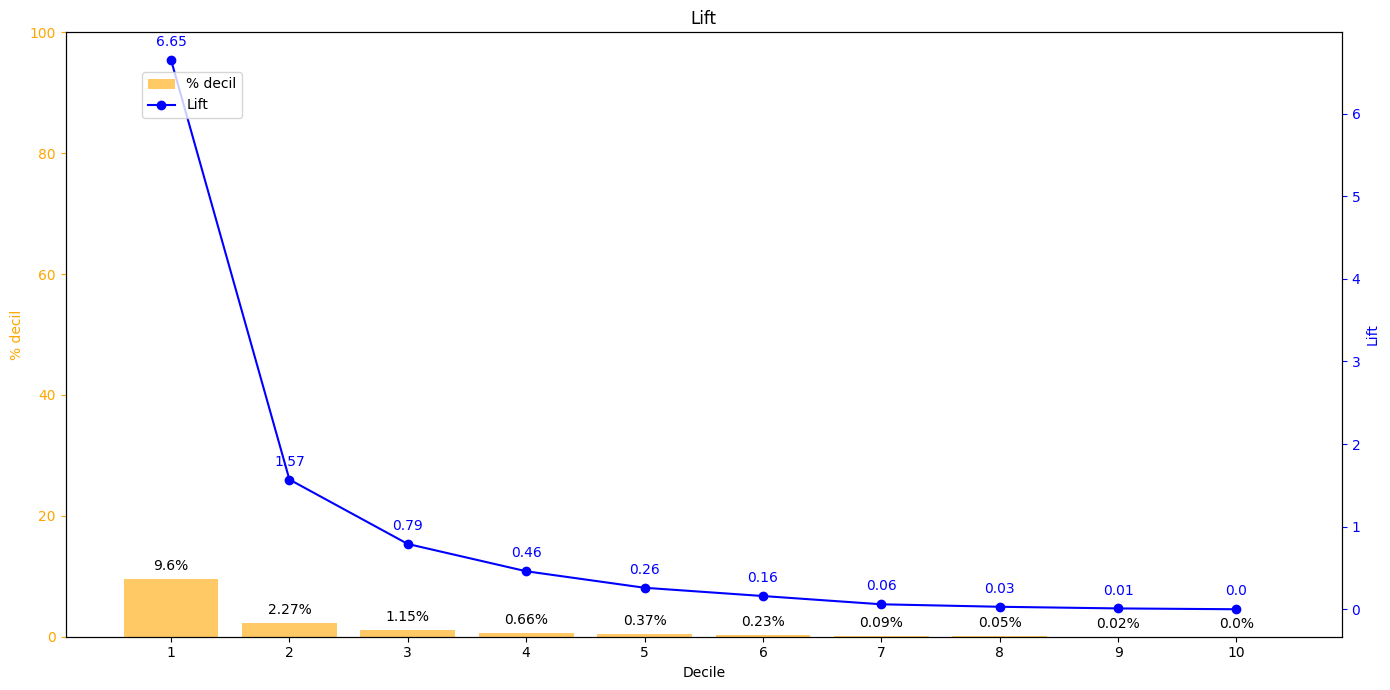

,decile,min_prob,max_prob,usuarios,usuarios_acumulado,casos_positivos,casos_positivos_acumulado,porcentaje_decile,Lift,porcentaje_aceptado,porcentaje_acumulado_aceptado,porcentaje_acumulado_total
0,1,0.164056,0.721570,48189,48189,4627,4627,9.60,6.65,66.52,66.52,10.0
1,2,0.123395,0.164054,48188,96377,1091,5718,2.26,1.57,15.68,82.20,20.0
2,3,0.104790,0.123394,48188,144565,553,6271,1.15,0.80,7.95,90.15,30.0
3,4,0.092142,0.104790,48188,192753,320,6591,0.66,0.46,4.60,94.75,40.0
4,5,0.082500,0.092142,48188,240941,179,6770,0.37,0.26,2.57,97.32,50.0
5,6,0.074659,0.082500,48189,289130,112,6882,0.23,0.16,1.61,98.93,60.0
6,7,0.068335,0.074659,48188,337318,41,6923,0.09,0.06,0.59,99.52,70.0
7,8,0.063123,0.068334,48188,385506,23,6946,0.05,0.03,0.33,99.85,80.0
8,9,0.058645,0.063123,48188,433694,9,6955,0.02,0.01,0.13,99.98,90.0
9,10,0.050687,0.058645,48189,481883,1,6956,0.00,0.00,0.01,99.99,100.0


In [146]:
create_and_analyze_summary(df_probar,num_groups=10,noise_indicator=True)